# Crime and rain: is there a correlation?

In this Jupyter Notebook, time series models are used to address the relation between property crime and rain for the city of Rio de Janeiro. Daily data for the years 2013 to 2017 were used to make short-term forecasting of property crime to the first month of 2017.

In [237]:
##### Libraries
import numpy as np
import pandas as pd
import os
import datetime as datetime
import matplotlib.pyplot as plt
from matplotlib import dates
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols, adfuller, grangercausalitytests, kpss
from statsmodels.tsa.statespace.tools import diff
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.tsa.ar_model import AR, ARResults
from statsmodels.tsa.arima_model import ARMA, ARMAResults, ARIMA, ARIMAResults
from statsmodels.tools.eval_measures import mse, rmse, meanabs
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from scipy import sparse
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import load_model
from numpy import array
from matplotlib import pyplot
from IPython.display import Image

In [24]:
##### Working directory
os.chdir("/Users/tauamagalhaes/Documents/Crime_and_rain")
print("Current Working Directory " , os.getcwd())

Current Working Directory  /Users/tauamagalhaes/Documents/Crime_and_rain


In [228]:
##### Dataset
crime = pd.read_csv("crime_data.csv", index_col = 'Date', parse_dates = True)
# Setting daily frequency
crime.index.freq = 'D'
# Looking at the first observation in the data
crime.head()

,Unnamed: 0,theft,rain,temperature,humidity,wind
Date,,,,,,
2016-01-01,1,27,0.0,29.22,72.50,1.333333
2016-01-02,2,41,1.3,26.38,83.75,1.133333
2016-01-03,3,54,3.1,26.10,75.50,2.400000
2016-01-04,4,69,0.0,26.36,67.50,1.866667
2016-01-05,5,66,0.0,25.66,72.25,2.266667


In [229]:
#### Descriptive statistics
crime.describe()

,Unnamed: 0,theft,rain,temperature,humidity,wind
count,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000
mean,199.000000,71.916877,2.926448,25.181612,64.328715,0.424139
std,114.748275,13.729554,9.681628,3.863753,26.106745,0.586837
min,1.000000,27.000000,0.000000,0.000000,0.000000,0.000000
25%,100.000000,64.000000,0.000000,22.660000,63.500000,0.000000
50%,199.000000,73.000000,0.000000,25.560000,73.500000,0.000000
75%,298.000000,81.000000,0.600000,28.080000,78.500000,0.800000
max,397.000000,113.000000,96.900000,33.460000,94.000000,2.800000


### Plot of the time series

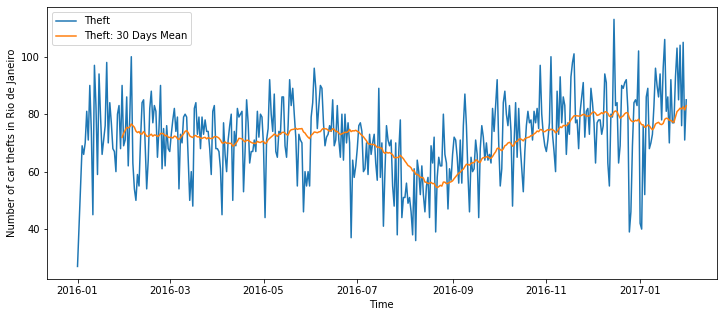

In [230]:
# Theft of vehicles
crime['Theft: 30 Days Mean'] = crime['theft'].rolling(window = 30).mean()
fig1, ax = plt.subplots(figsize = (12,5))
ax.plot(crime['theft'], label = 'Theft')
ax.plot(crime['Theft: 30 Days Mean'], label = 'Theft: 30 Days Mean')
ax.set(xlabel = 'Time', ylabel = 'Number of car thefts in Rio de Janeiro')
leg = ax.legend()

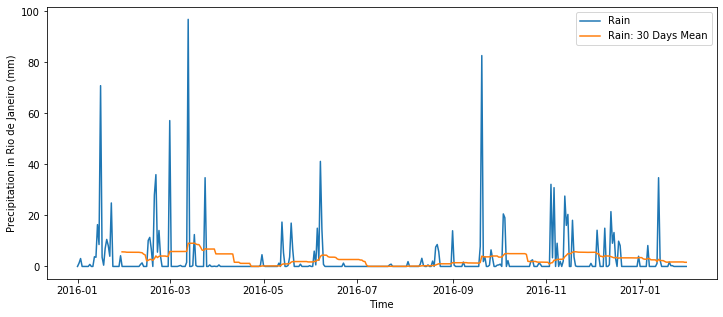

In [29]:
# Rain
crime['Rain: 30 Days Mean'] = crime['rain'].rolling(window = 30).mean()
fig2, ax2 = plt.subplots(figsize = (12,5))
ax2.plot(crime['rain'], label = 'Rain')
ax2.plot(crime['Rain: 30 Days Mean'], label = 'Rain: 30 Days Mean')
ax2.set(xlabel = 'Time', ylabel = 'Precipitation in Rio de Janeiro (mm)')
leg2 = ax2.legend()

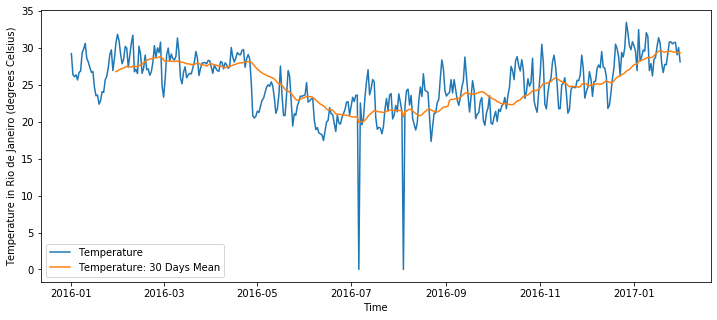

In [30]:
# Temperature
crime['Temperature: 30 Days Mean'] = crime['temperature'].rolling(window = 30).mean()
# Plot
fig3, ax3 = plt.subplots(figsize = (12,5))
ax3.plot(crime['temperature'], label = 'Temperature')
ax3.plot(crime['Temperature: 30 Days Mean'], label = 'Temperature: 30 Days Mean')
ax3.set(xlabel = 'Time', ylabel = 'Temperature in Rio de Janeiro (degrees Celsius)')
leg3 = ax3.legend()

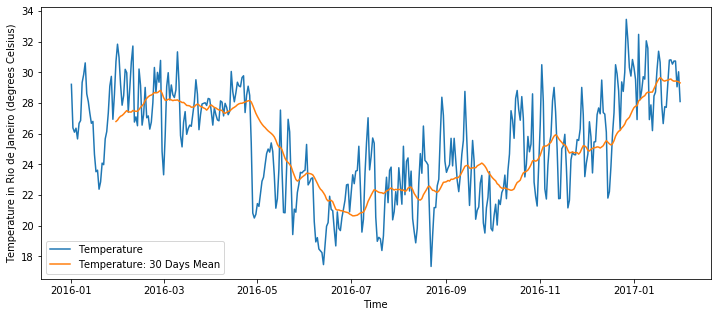

In [31]:
# Temperature
# There was two values in temperature with zero, so we replace it with the mean
crime['temperature'] = crime['temperature'].replace(0, crime['temperature'].mean()) 
# Rolling 30 day mean
crime['Temperature: 30 Days Mean'] = crime['temperature'].rolling(window = 30).mean()
# Plot
fig3, ax3 = plt.subplots(figsize = (12,5))
ax3.plot(crime['temperature'], label = 'Temperature')
ax3.plot(crime['Temperature: 30 Days Mean'], label = 'Temperature: 30 Days Mean')
ax3.set(xlabel = 'Time', ylabel = 'Temperature in Rio de Janeiro (degrees Celsius)')
leg3 = ax3.legend()

### ETS Decomposition

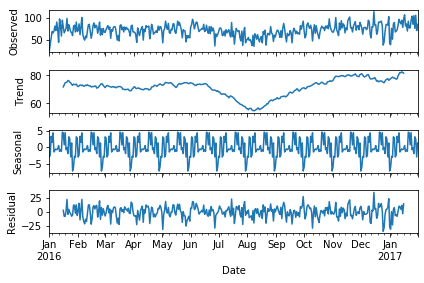

In [234]:
## Car theft
ets_crime = seasonal_decompose(crime['theft'], model = 'additive', freq = 31)
ets_crime.plot();

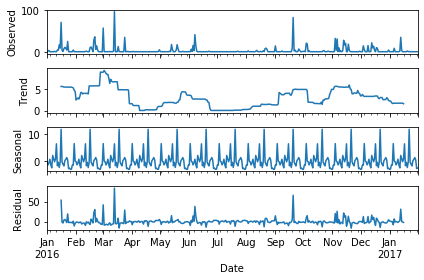

In [39]:
## Rain
ets_rain = seasonal_decompose(crime['rain'], model = 'additive', freq = 31)
ets_rain.plot();
# The same for rain, montlhy seasonality

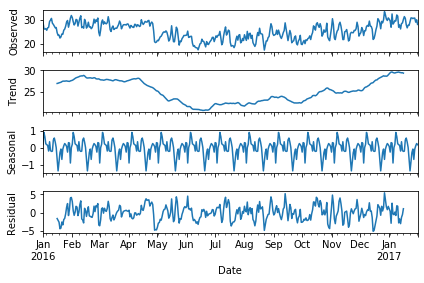

In [41]:
## Temperature
ets_temp = seasonal_decompose(crime['temperature'], model = 'additive', freq = 31)
ets_temp.plot();
# The same for temperature, montlhy seasonality

### ACF and PACF plots

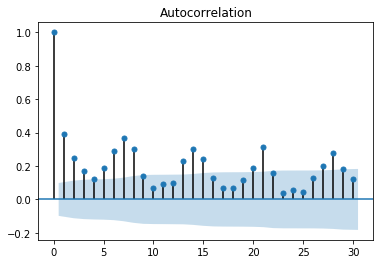

In [44]:
# ACF plot of car theft
plot_acf(crime['theft'], lags = 30);

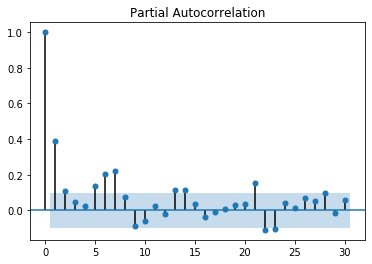

In [45]:
# PACF plot of car theft
plot_pacf(crime['theft'], lags = 30);

The ACF and PACF for both time series of car theft and robbery did not reveal much about the underlying structure of the series. Therefore, we will implement the Augmented Dickey Fuller test to see if both the time series have a unit root.

### Augmented Dickey-Fuller test for unit root

A lot of researchers and data scientists find trouble interpreting the results of the ADF test for stationarity. This function below intends to make the interpretation of the test easier.

In [76]:
def adf_test(series, title=''):

    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag = 'AIC', regression = 'ct')
    # Considering a constant and trend
    # The number of lags are determined by the AIC criteria
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())  
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [75]:
adf_test(crime['theft'], 'Car theft and robbery')

Augmented Dickey-Fuller Test: Car theft and robbery
ADF test statistic       -2.459015
p-value                   0.348747
# lags used              13.000000
# observations          383.000000
critical value (1%)      -3.982604
critical value (5%)      -3.422016
critical value (10%)     -3.133828
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


As it can be seen, the function returns a much easier way to interpret the ADF test. The results show a statistically significant evidence against the null hypothesis that the car theft and robbery has a uniti root (considering conventional levels of significance). Therefore, we have evidence that the car theft series is not stationary.

### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for unit root

The KPSS test for unit root has the same goal as the ADF test. But while in the ADF, the null hypothesis is that the series has a unit root, in the KPSS, the null hypothesis is that the series does not have a unit root. The function below helps to interpret the results.

In [70]:
def kpss_test(series, title=''):

    print(f'KPSS Test: {title}')
    result = kpss(series.dropna(), regression='ct')
    
    labels = ['KPSS test statistic','p-value','# lags used']
    out = pd.Series(result[0:3],index = labels)

    for key,val in result[3].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())  
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has no unit root and is stationary")

In [72]:
kpss_test(crime['theft'], 'Car theft and robbery')

KPSS Test: Car theft and robbery
KPSS test statistic       0.300128
p-value                   0.010000
# lags used              17.000000
critical value (10%)      0.119000
critical value (5%)       0.146000
critical value (2.5%)     0.176000
critical value (1%)       0.216000
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has a unit root and is non-stationary


/Users/tauamagalhaes/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


Looking at the KPSS test for unit root we have another evidence that the car theft series has a unit root and needs to be differentiated.

### Granger causality test

The Null hypothesis for the Granger causality test is that the time series in the second column, x2, does NOT Granger cause the time series in the first column, x1. Granger causality means that past values of x2 have a statistically significant effect on the current value of x1, taking past values of x1 into account as regressors. We reject the null hypothesis that x2 does not Granger cause x1 if the pvalues are below a desired size of the test.

In [100]:
grangercausalitytests(crime[['theft', 'rain']], maxlag = 10);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0018  , p=0.9662  , df_denom=393, df_num=1
ssr based chi2 test:   chi2=0.0018  , p=0.9660  , df=1
likelihood ratio test: chi2=0.0018  , p=0.9660  , df=1
parameter F test:         F=0.0018  , p=0.9662  , df_denom=393, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0029  , p=0.9972  , df_denom=390, df_num=2
ssr based chi2 test:   chi2=0.0058  , p=0.9971  , df=2
likelihood ratio test: chi2=0.0058  , p=0.9971  , df=2
parameter F test:         F=0.0029  , p=0.9972  , df_denom=390, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0100  , p=0.9986  , df_denom=387, df_num=3
ssr based chi2 test:   chi2=0.0305  , p=0.9986  , df=3
likelihood ratio test: chi2=0.0305  , p=0.9986  , df=3
parameter F test:         F=0.0100  , p=0.9986  , df_denom=387, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7229  , p=0.1441  

We did not reject the null hypothesis that past values of precipitation Granger cause the number of car thefts and robbery. In other words, this could be an indicate that the criminals plan ahead when it is rainning. To address this issue in the estimation we will create a variable of representing the moving average of rain and include as an exogenous regressor in the ARIMA model.

In [102]:
grangercausalitytests(crime[['theft', 'temperature']], maxlag = 10);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.7719  , p=0.0032  , df_denom=393, df_num=1
ssr based chi2 test:   chi2=8.8389  , p=0.0029  , df=1
likelihood ratio test: chi2=8.7417  , p=0.0031  , df=1
parameter F test:         F=8.7719  , p=0.0032  , df_denom=393, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.9705  , p=0.0004  , df_denom=390, df_num=2
ssr based chi2 test:   chi2=16.1454 , p=0.0003  , df=2
likelihood ratio test: chi2=15.8242 , p=0.0004  , df=2
parameter F test:         F=7.9705  , p=0.0004  , df_denom=390, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.3339  , p=0.0013  , df_denom=387, df_num=3
ssr based chi2 test:   chi2=16.2911 , p=0.0010  , df=3
likelihood ratio test: chi2=15.9633 , p=0.0012  , df=3
parameter F test:         F=5.3339  , p=0.0013  , df_denom=387, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.8913  , p=0.0041  

On the other hand, for temperature we rejected the null hypothesis that past values of temperature Granger cause the number of car thefts and robbery.

## How we are going to analyse the relation between crime and weather?

We will address this problem based on two approaches. First, we  consider a linear approach through an ARIMA(p,d,q) model with precipitation and rain as a exogenous regressors. 

\begin{equation}
    crime_t = \alpha_0 + A(L) crime_{t-1} + c_{0} rain_t + c_{1} temperature_t +  B(L)\epsilon_t
\end{equation}

We assume that the input process $rain_t$ and the white noise process $\epsilon_t$ are boht stationary and mutually independent. $\textit{A(L)}$ and $\textit{B(L)}$ are polynomials in the lag operator assigning weights to past values of $crime_t$ and $\epsilon_t$.

## Car theft and robbery

In [235]:
##### Taking the first order difference of the series
crime['diff_theft'] = diff(crime['theft'], k_diff = 1)
##### Including a ten days moving window average for rain
crime['ma_rain'] = crime['rain'].rolling(window = 10).mean()

In [198]:
##### Splitting the data
train_data = crime.iloc[:366]
test_data = crime.iloc[366:397]
start = len(train_data['theft'])
end = (len(train_data['theft']) + len(test_data['theft']) - 1)

In [199]:
##### Using auto_arima function to help identify the best order for the ARIMA model
# Auto ARIMA with only theft
fit_auto_arima = auto_arima(train_data['theft'], start_p = 0, start_q = 0, max_p = 6, 
                            max_q = 6, seasonal = True, trace = True)
fit_auto_arima.summary()

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=2983.097, BIC=2990.897, Fit time=0.053 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=2935.578, BIC=2947.278, Fit time=0.118 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=2861.977, BIC=2873.677, Fit time=0.299 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=2981.172, BIC=2985.072, Fit time=0.034 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=2845.537, BIC=2861.137, Fit time=0.694 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=2847.135, BIC=2866.635, Fit time=1.001 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=2847.288, BIC=2866.787, Fit time=0.976 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=2845.868, BIC=2861.468, Fit time=0.383 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=2917.117, BIC=2932.717, Fit time=0.666 seconds


/Users/tauamagalhaes/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/tauamagalhaes/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=2848.214, BIC=2871.613, Fit time=1.620 seconds
Total fit time: 5.882 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  366
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1418.769
Date:                Wed, 23 Sep 2020   AIC                           2845.537
Time:                        15:17:56   BIC                           2861.137
Sample:                             0   HQIC                          2851.737
                                - 366                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0285      0.045      0.638      0.523      -0.059       0.116
ar.L1          0.2476      0.057      4.371      0.000       0.137       0.359
ma.L1         -0.9338      0.022    -41.998      0.000      -0.977      -0.890
sigma2       138.6333      9.383     14.775      0.000     120.243     157.023
===================================================================================
Ljung-Box (Q):                      124.99   Jarque-Bera (JB):                 7.08
Prob(Q):                              0.00   Prob(JB):                         0.03
Heteroskedasticity (H):               0.90   Skew:                            -0.22
Prob(H) (two-sided):                  0.55   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [200]:
##### ARIMA(1,1,1)
model_arima = SARIMAX(train_data['theft'], order = (1,1,1), freq = 'D')
results_arima = model_arima.fit()
results_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  theft   No. Observations:                  366
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1418.993
Date:                Wed, 23 Sep 2020   AIC                           2843.986
Time:                        15:18:01   BIC                           2855.686
Sample:                    01-01-2016   HQIC                          2848.636
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2473      0.057      4.359      0.000       0.136       0.359
ma.L1         -0.9328      0.023    -41.216      0.000      -0.977      -0.888
sigma2       138.8079      9.293     14.937      0.000     120.594     157.022
===================================================================================
Ljung-Box (Q):                      125.44   Jarque-Bera (JB):                 7.11
Prob(Q):                              0.00   Prob(JB):                         0.03
Heteroskedasticity (H):               0.91   Skew:                            -0.22
Prob(H) (two-sided):                  0.59   Kurtosis:                         3.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

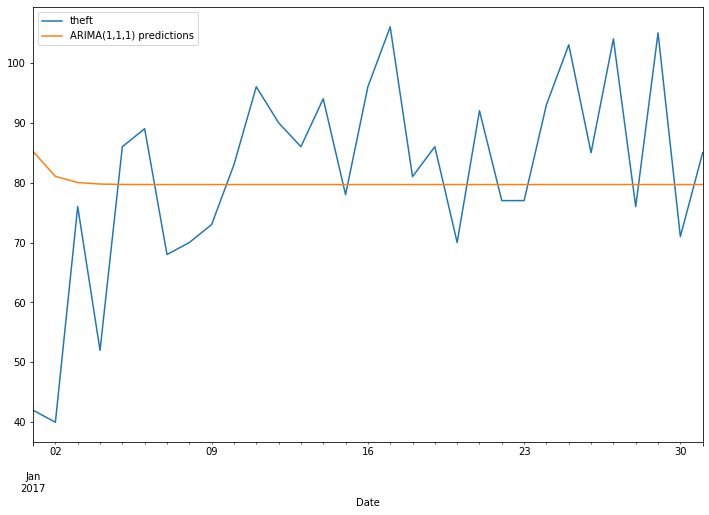

In [201]:
# Predictions
predictions_arima = results_arima.predict(start, end, typ = 'levels')
predictions_arima = predictions_arima.rename('ARIMA(1,1,1) predictions')
# Plot
test_data['theft'].plot(figsize = (12,8), legend = True)
predictions_arima.plot(legend = True)

In [202]:
#### Evalution metrics
# RMSE
rmse(test_data['theft'], predictions_arima)

16.782349489522254

In [203]:
# MSE
mse(test_data['theft'], predictions_arima)

281.64725438846784

In [204]:
# MAE
mean_absolute_error(test_data['theft'], predictions_arima)

12.867593792247835

### Rain and temperature as exogenous regressors

Now what we are going to do is including precipitation and rain as exogenous regressors and see if there is an improve in the evaluation metrics in the prediction. In the positive case we can assume that there is a relation between them.

In [205]:
# Auto ARIMA with rain and temperature as exogenoues variables
fit_auto_arima_temp_rain = auto_arima(train_data['theft'], exogenous = (train_data[['rain','temperature']]),
                            start_p = 0, start_q = 0, max_p = 6, 
                            max_q = 6, seasonal = True, trace = True)
fit_auto_arima_temp_rain.summary()

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=2983.849, BIC=2999.449, Fit time=0.100 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=2934.209, BIC=2953.708, Fit time=0.302 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=2860.034, BIC=2879.533, Fit time=0.662 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=2981.924, BIC=2993.624, Fit time=0.364 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=2844.446, BIC=2867.845, Fit time=0.911 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=2846.194, BIC=2873.494, Fit time=0.955 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=2846.296, BIC=2873.595, Fit time=0.838 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=2844.937, BIC=2868.337, Fit time=0.688 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=2916.645, BIC=2940.044, Fit time=1.055 seconds


/Users/tauamagalhaes/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=2847.179, BIC=2878.378, Fit time=1.721 seconds
Total fit time: 7.627 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  366
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1416.223
Date:                Wed, 23 Sep 2020   AIC                           2844.446
Time:                        15:18:38   BIC                           2867.845
Sample:                    01-01-2016   HQIC                          2853.745
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept       0.0294      0.045      0.658      0.511      -0.058       0.117
rain            0.1245      0.053      2.355      0.019       0.021       0.228
temperature    -0.1518      0.252     -0.601      0.548      -0.646       0.343
ar.L1           0.2403      0.057      4.244      0.000       0.129       0.351
ma.L1          -0.9338      0.022    -42.622      0.000      -0.977      -0.891
sigma2        136.7068      9.387     14.563      0.000     118.308     155.106
===================================================================================
Ljung-Box (Q):                      131.23   Jarque-Bera (JB):                 7.26
Prob(Q):                              0.00   Prob(JB):                         0.03
Heteroskedasticity (H):               0.86   Skew:                            -0.24
Prob(H) (two-sided):                  0.39   Kurtosis:                         3.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [206]:
##### ARIMA(1,1,1) with rain and temperature as exogenous regressors
model_arima_temp_rain = SARIMAX(train_data['theft'], order = (1,1,1), exog = (train_data[['rain','temperature']]),
                    freq = 'D')
results_arima_temp_rain = model_arima_temp_rain.fit()
results_arima_temp_rain.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  theft   No. Observations:                  366
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1416.465
Date:                Wed, 23 Sep 2020   AIC                           2842.931
Time:                        15:18:52   BIC                           2862.430
Sample:                    01-01-2016   HQIC                          2850.680
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
rain            0.1242      0.054      2.320      0.020       0.019       0.229
temperature    -0.1509      0.257     -0.587      0.557      -0.655       0.353
ar.L1           0.2402      0.057      4.231      0.000       0.129       0.351
ma.L1          -0.9328      0.022    -41.732      0.000      -0.977      -0.889
sigma2        136.8956      9.280     14.751      0.000     118.706     155.085
===================================================================================
Ljung-Box (Q):                      131.72   Jarque-Bera (JB):                 7.31
Prob(Q):                              0.00   Prob(JB):                         0.03
Heteroskedasticity (H):               0.86   Skew:                            -0.24
Prob(H) (two-sided):                  0.42   Kurtosis:                         3.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

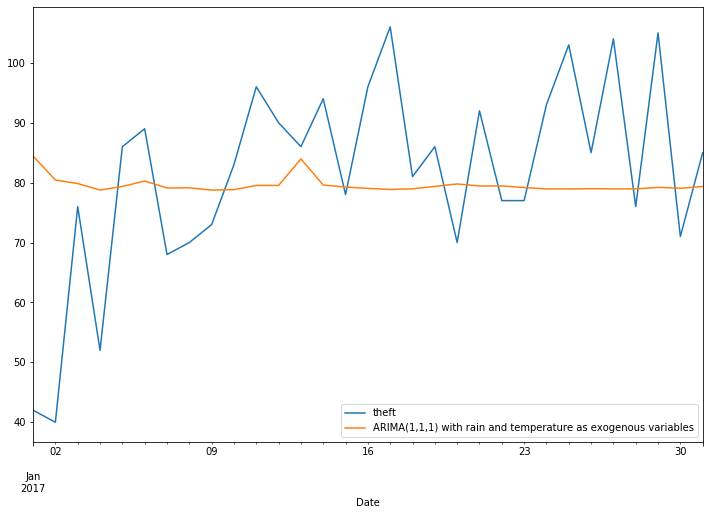

In [207]:
# Predictions
predictions_arima_exog = results_arima_temp_rain.predict(start, end, exog = (test_data[['rain','temperature']]),
                                                         typ = 'levels')
predictions_arima_exog = predictions_arima_exog.rename('ARIMA(1,1,1) with rain and temperature as exogenous variables')
# Plot
test_data['theft'].plot(figsize = (12,8), legend = True)
predictions_arima_exog.plot(legend = True)

In [208]:
#### Evalution metrics
# RMSE
rmse(test_data['theft'], predictions_arima_exog)

16.739513753075954

In [209]:
# MSE
mse(test_data['theft'], predictions_arima_exog)

280.211320689419

In [210]:
# MAE
mean_absolute_error(test_data['theft'], predictions_arima_exog)

12.743018478368636

#### Moving average precipitation

Now that we saw that temperature and precipitation did improve a little bit the evaluation metrics in the predictions, let's see if the ten days moving average of precipitation does.

In [212]:
##### Splitting the data
train_data = crime.iloc[10:366]
test_data = crime.iloc[366:397]
start = len(train_data['theft'])
end = (len(train_data['theft']) + len(test_data['theft']) - 1)
# Auto ARIMA with moving average of rain as exogenoues variables
fit_auto_arima_ma_rain = auto_arima(train_data['theft'], exogenous = (train_data[['ma_rain']]),
                            start_p = 0, start_q = 0, max_p = 6, 
                            max_q = 6, seasonal = True, trace = True)
fit_auto_arima_ma_rain.summary()

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=2901.860, BIC=2913.476, Fit time=0.040 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=2855.884, BIC=2871.373, Fit time=0.479 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=2767.267, BIC=2782.756, Fit time=0.583 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=2899.905, BIC=2907.649, Fit time=0.167 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=2755.050, BIC=2774.410, Fit time=1.152 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=2756.030, BIC=2779.263, Fit time=0.985 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=2756.541, BIC=2779.773, Fit time=0.929 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=2754.694, BIC=2774.055, Fit time=0.424 seconds


/Users/tauamagalhaes/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fit ARIMA: order=(1, 1, 3) seasonal_order=(0, 0, 0, 1); AIC=2758.167, BIC=2785.272, Fit time=1.520 seconds
Fit ARIMA: order=(0, 1, 3) seasonal_order=(0, 0, 0, 1); AIC=2756.384, BIC=2779.616, Fit time=1.066 seconds
Total fit time: 7.441 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  356
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -1372.347
Date:                Wed, 23 Sep 2020   AIC                           2754.694
Time:                        15:20:15   BIC                           2774.055
Sample:                    01-11-2016   HQIC                          2762.397
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0209      0.053      0.394      0.694      -0.083       0.125
ma_rain        0.4672      0.250      1.872      0.061      -0.022       0.956
ma.L1         -0.7227      0.056    -13.008      0.000      -0.832      -0.614
ma.L2         -0.1981      0.053     -3.729      0.000      -0.302      -0.094
sigma2       132.7781      9.048     14.675      0.000     115.045     150.511
===================================================================================
Ljung-Box (Q):                      141.71   Jarque-Bera (JB):                 7.69
Prob(Q):                              0.00   Prob(JB):                         0.02
Heteroskedasticity (H):               1.00   Skew:                            -0.20
Prob(H) (two-sided):                  1.00   Kurtosis:                         3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [213]:
##### ARIMA(0,1,2) with ma_rain as exogenous regressors
model_arima_ma_rain = SARIMAX(train_data['theft'], order = (0,1,2), exog = (train_data[['ma_rain']]),
                    freq = 'D')
results_arima_ma_rain = model_arima_ma_rain.fit()
results_arima_ma_rain.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  theft   No. Observations:                  356
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -1372.432
Date:                Wed, 23 Sep 2020   AIC                           2752.864
Time:                        15:20:19   BIC                           2768.353
Sample:                    01-11-2016   HQIC                          2759.026
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma_rain        0.4624      0.249      1.856      0.064      -0.026       0.951
ma.L1         -0.7224      0.056    -13.006      0.000      -0.831      -0.614
ma.L2         -0.1975      0.053     -3.715      0.000      -0.302      -0.093
sigma2       132.8495      8.912     14.906      0.000     115.382     150.317
===================================================================================
Ljung-Box (Q):                      141.92   Jarque-Bera (JB):                 7.56
Prob(Q):                              0.00   Prob(JB):                         0.02
Heteroskedasticity (H):               1.01   Skew:                            -0.20
Prob(H) (two-sided):                  0.98   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

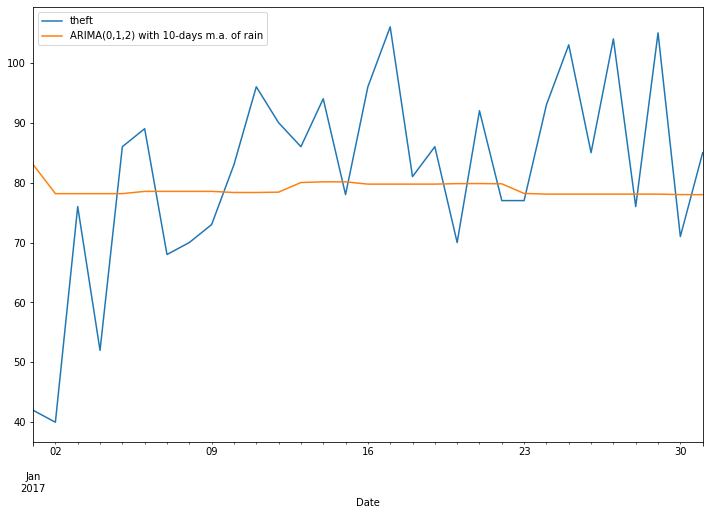

In [214]:
# Predictions
predictions_arima_ma_rain = results_arima_ma_rain.predict(start, end, exog = (test_data[['ma_rain']]),
                                                         typ = 'levels')
predictions_arima_ma_rain = predictions_arima_ma_rain.rename('ARIMA(0,1,2) with 10-days m.a. of rain')
# Plot
test_data['theft'].plot(figsize = (12,8), legend = True)
predictions_arima_ma_rain.plot(legend = True)

In [215]:
#### Evalution metrics
# RMSE
rmse(test_data['theft'], predictions_arima_ma_rain)

16.609076218997334

In [216]:
# MSE
mse(test_data['theft'], predictions_arima_ma_rain)

275.8614128484628

In [218]:
# MAE
mean_absolute_error(test_data['theft'], predictions_arima_ma_rain)

12.83716415489242

Considering the 10 days moving average of precipitation improve even more the evaluation metrics in the predictions.

## LSTM Artificial Neural Network

Relaxing the linear hypothesis, we employed a Long Short-Term Memory (LSTM) deep neural network with two hidden layers.

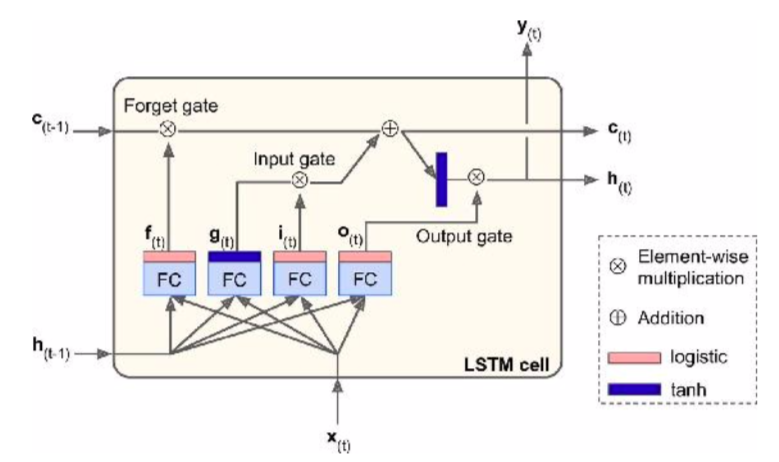

In [238]:
Image('LSTM.png')

In [263]:
### Fixing random seed for reproducibility
np.random.seed(7)

### Reading the data again
crime_ann = pd.read_csv("crime_data.csv", index_col = 'Date', parse_dates = True)
crime_ann.index.freq = 'D'

### Splitting the data
train_nn = crime_ann.iloc[:366]
test_nn = crime_ann.iloc[366:397]

### Scaling the data
scaler = MinMaxScaler()
scaler_crime_train = scaler.fit(train_nn[['theft']])
std_train_crime = scaler.transform(train_nn[['theft']])
std_test_crime = scaler.transform(test_nn[['theft']])

### Time Series Generator
n_input = 10
n_features= 1
generator = TimeseriesGenerator(std_train_crime, std_train_crime, length = n_input, batch_size = 1)

##### LSTM with two layers
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_input,n_features), return_sequences = True))
model.add(Dropout(.4))
model.add(LSTM(100, activation='relu', return_sequences = False))
model.add(Dropout(.4))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# Summary
model_ann.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 50)                10400     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [264]:
## Training the model
model_ann.fit_generator(generator, epochs = 10)

Epoch 1/10
356/356 [==============================] - 5s 13ms/step - loss: 0.0192
Epoch 2/10
356/356 [==============================] - 4s 12ms/step - loss: 0.0193
Epoch 3/10
356/356 [==============================] - 4s 12ms/step - loss: 0.0192
Epoch 4/10
356/356 [==============================] - 4s 12ms/step - loss: 0.0190
Epoch 5/10
356/356 [==============================] - 5s 14ms/step - loss: 0.0190
Epoch 6/10
356/356 [==============================] - 5s 14ms/step - loss: 0.0190
Epoch 7/10
356/356 [==============================] - 5s 13ms/step - loss: 0.0189
Epoch 8/10
356/356 [==============================] - 5s 13ms/step - loss: 0.0188
Epoch 9/10
356/356 [==============================] - 5s 15ms/step - loss: 0.0178
Epoch 10/10
356/356 [==============================] - 4s 12ms/step - loss: 0.0184


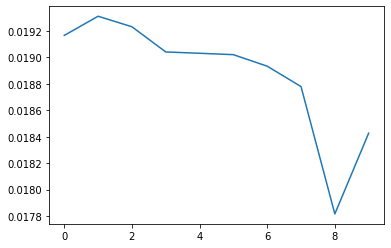

In [265]:
# Plot the loss per epoch
model_ann.history.history.keys()
loss_per_epoch = model_ann.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

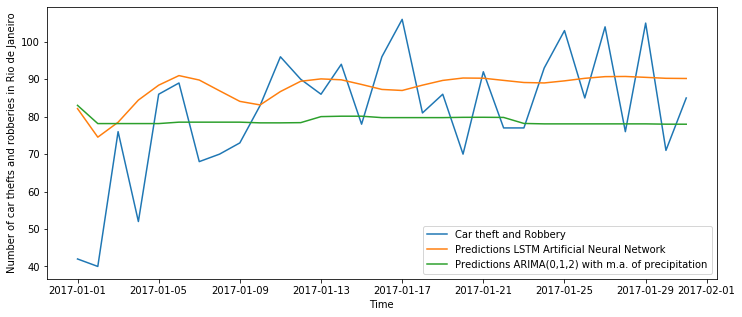

In [268]:
## Evaluating the model in the test data
# Reshaping the data
test_predictions = []
first_eval_batch = std_train_crime[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
for i in range(len(test_nn)):
    current_pred = model_ann.predict(current_batch)[0]
    test_predictions.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
true_predictions = scaler.inverse_transform(test_predictions)
test_data['predictions_lstm'] = true_predictions
# Plot
fig4, ax4 = plt.subplots(figsize = (12,5))
ax4.plot(test_data['theft'], label = 'Car theft and Robbery')
ax4.plot(test_data['predictions_lstm'], label = 'Predictions LSTM Artificial Neural Network')
ax4.plot(predictions_arima_ma_rain, label = 'Predictions ARIMA(0,1,2) with m.a. of precipitation')
ax4.set(xlabel = 'Time', ylabel = 'Number of car thefts and robberies in Rio de Janeiro')
leg4 = ax4.legend()

In [269]:
##### Evaluation metrics
# RMSE
rmse(test_data['theft'], test_data['predictions_lstm'])

15.499253449693324

In [270]:
# MSE
mse(test_data['theft'], test_data['predictions_lstm'])

240.22685749783042

In [271]:
# MAE
mean_absolute_error(test_data['theft'], test_data['predictions_lstm'])

11.871788036438728

As we can see the LSTM neural nets performs better than the ARIMA models in terms of prediction accuracy.